# Analysis of candlestick patterns 01

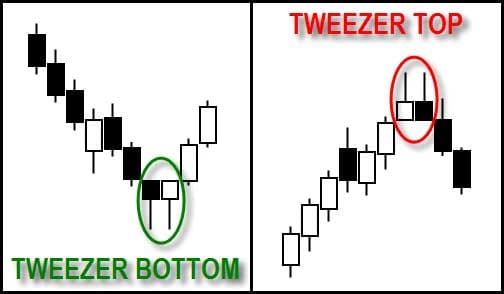

In [10]:
import pandas as pd
df1 = pd.read_csv('CandleData.csv',delimiter=';')  
df2 = pd.read_csv('PatternExtra.csv')
df2.rename(columns={'Candlestick Pattern': 'Pattern Description'}, inplace=True)
df = pd.merge(df1, df2, on='Pattern Description', how='left')
df.drop(columns=['Num'], inplace=True)
df.rename(columns={'Breakout dendency': 'Breakout dependency'}, inplace=True)
df.head()

,Stock,Last Close,Pattern Description,Start,End,Breakout Date,Ultimate H/L Date,Breakout,Approx BP,Fill Price,...,Break to reach,End to break,End to reach,Time Classify,Breakout dependency,Num,Type of Pattern,Price Trend Leading to Pattern,Bullish/Bearish/Both,Breakout Direction
0,AALI.JK,6075,Southern doji,17/04/2023,17/04/2023,26/04/2023,31/05/2023,Down,7825.0,7675.0,...,0,9,9,Short,Dependent,1.0,Reversal,Down,Bullish,Up
1,AALI.JK,6075,Southern doji,18/04/2023,18/04/2023,26/04/2023,31/05/2023,Down,7850.0,7675.0,...,0,8,8,Short,Dependent,1.0,Reversal,Down,Bullish,Up
2,AALI.JK,6075,Long black day,26/04/2023,26/04/2023,04/05/2023,31/05/2023,Down,7650.0,7550.0,...,1,8,9,Short,Independent,2.0,Continuation,Down,Bearish,Down
3,AALI.JK,6075,Spinning top,27/04/2023,27/04/2023,04/05/2023,31/05/2023,Down,7600.0,7550.0,...,1,7,8,Short,Independent,3.0,Indecision,Any,Both,Both
4,AALI.JK,6075,Black spinning top,27/04/2023,27/04/2023,04/05/2023,31/05/2023,Down,7600.0,7550.0,...,1,7,8,Short,Independent,4.0,Indecision,Any,Bearish,Down


# Data for finished patterns

In [15]:
df_f = df[df['Reached On'].notna()]
print(df_f.shape,df.shape)

(240348, 27) (288502, 27)


# Eliminate indecision patterns

In [22]:
df_f = df_f[df_f['Type of Pattern'] != 'Indecision']
df_f['Type of Pattern'].value_counts()

Type of Pattern
Reversal        112599
Continuation     72327
Name: count, dtype: int64

# Mapping breakout success rate

In [28]:
import numpy as np

# Assuming:
# 'Bullish/Bearish/Both' indicates the pattern type and can be "Bullish" or "Bearish"
# 'Breakout Direction' indicates the *expected* breakout direction (either "Up" or "Down")
# 'Breakout' indicates the *actual* breakout direction (either "Up" or "Down")

df_f['Breakout result'] = np.where(
    ((df_f['Bullish/Bearish/Both'] == 'Bullish') & (df_f['Breakout'] == 'Up')) |
    ((df_f['Bullish/Bearish/Both'] == 'Bearish') & (df_f['Breakout'] == 'Down')),
    'Success',
    'Fail'
)

# Fixing the dates

In [35]:
df_f['Reach/Stop Date'] = df_f['Trade Status'].str.extract(r'(\d{4}-\d{2}-\d{2})')
df_f['Reach/Stop Date'] = pd.to_datetime(df_f['Reach/Stop Date']).dt.strftime('%m/%d/%Y')

# Calculating the durations

In [39]:
df_f = df_f[['Pattern Description','Bullish/Bearish/Both', 'Start', 'End',
       'Breakout Date', 'Reach/Stop Date',
      'Breakout','Avg 3 Mo. Volume','Breakout result','Trade Status','Type of Pattern']]

In [42]:
df_f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187795 entries, 0 to 288484
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Pattern Description   187795 non-null  object
 1   Bullish/Bearish/Both  184926 non-null  object
 2   Start                 187795 non-null  object
 3   End                   187795 non-null  object
 4   Breakout Date         187795 non-null  object
 5   Reach/Stop Date       187795 non-null  object
 6   Breakout              187795 non-null  object
 7   Avg 3 Mo. Volume      187795 non-null  int64 
 8   Breakout result       187795 non-null  object
 9   Trade Status          187795 non-null  object
 10  Type of Pattern       184926 non-null  object
dtypes: int64(1), object(10)
memory usage: 17.2+ MB


In [46]:
import pandas as pd

# Convert the relevant columns to datetime
df_f['Start'] = pd.to_datetime(df_f['Start'], format='%d/%m/%Y')
df_f['End'] = pd.to_datetime(df_f['End'], format='%d/%m/%Y')
df_f['Breakout Date'] = pd.to_datetime(df_f['Breakout Date'], format='%d/%m/%Y')
df_f['Reach/Stop Date'] = pd.to_datetime(df_f['Reach/Stop Date'], format='%m/%d/%Y', errors='coerce')

# Replace NaN with a default date (optional, or you can drop rows with NaN)
df_f['Reach/Stop Date'] = df_f['Reach/Stop Date'].fillna(pd.NaT)

# Calculate the new columns
df_f['Pattern length'] = (df_f['End'] - df_f['Start']).dt.days
df_f['Pattern to break'] = (df_f['Breakout Date'] - df_f['End']).dt.days

# Ensure no subtraction happens on NaN
df_f['Break to reach/stop'] = (
    (df_f['Reach/Stop Date'] - df_f['Breakout Date'])
    .dt.days.fillna(0).astype(int)  # Optional: Handle NaN as 0
)

df_f['Trade Status'] = df_f['Trade Status'].str.strip().str.lower().apply(
    lambda x: 'Triggered' if 'stop' in x else 'Reached')

# Manuually remove bad patterns

In [54]:
# removing Southern doji
df_f = df_f[df_f['Pattern Description'] != 'Southern doji']

# Categorizing the patterns

In [59]:
# reversal
bur = df_f.loc[(df_f['Bullish/Bearish/Both'] == 'Bullish') & (df_f['Type of Pattern'] == 'Reversal')]
ber = df_f.loc[(df_f['Bullish/Bearish/Both'] == 'Bearish') & (df_f['Type of Pattern'] == 'Reversal')]

# continuation
buc = df_f.loc[(df_f['Bullish/Bearish/Both'] == 'Bullish') & (df_f['Type of Pattern'] == 'Continuation')]
bec = df_f.loc[(df_f['Bullish/Bearish/Both'] == 'Bearish') & (df_f['Type of Pattern'] == 'Continuation')]

# Function for analyzing the patterns

In [82]:
# lets dig deeper 

def analyze_trade_table(df):
    """
    Analyze a prepared trade table to compute:
    1. Average, median, and standard deviation of specific columns.
    2. Success rate based on 'Trade Status'.
    3. Occurrences of each 'Pattern Description'.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.

    Returns:
    - pd.DataFrame: Analysis results with statistics, success rates, and occurrences.
    """
    # Compute average, median, and standard deviation for specific numeric columns
    stats = df.groupby('Pattern Description')[['Pattern length', 'Pattern to break', 'Break to reach/stop']].agg(
        ['mean', 'median', 'std']
    )
    
    # Flatten the multi-level column index of stats
    stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
    
    # Compute success rate for 'Trade Status'
    success_rate = df.groupby('Pattern Description')['Trade Status'].apply(
        lambda x: (x == 'Reached').sum() / len(x) * 100
    ).reset_index(name='Success Rate (%)')

     # Compute success rate for 'Breakout result'
    breakout_success_rate = df.groupby('Pattern Description')['Breakout result'].apply(
        lambda x: (x == 'Success').sum() / len(x) * 100
    ).reset_index(name='Breakout Success Rate (%)')

    
    # Count occurrences of each 'Pattern Description'
    occurrences = df.groupby('Pattern Description').size().reset_index(name='Occurrences')
    
    # Merge all results into a single DataFrame
    result = stats.merge(success_rate, on='Pattern Description', how='left')
    result = result.merge(breakout_success_rate, on='Pattern Description', how='left')
    result = result.merge(occurrences, on='Pattern Description', how='left')
    
    return result


In [213]:
data = analyze_trade_table(bur)

In [215]:
data

,Pattern Description,Pattern length_mean,Pattern length_median,Pattern length_std,Pattern to break_mean,Pattern to break_median,Pattern to break_std,Break to reach/stop_mean,Break to reach/stop_median,Break to reach/stop_std,Success Rate (%),Breakout Success Rate (%),Occurrences
0,3 outside up,3.273642,3.0,1.578292,14.069416,7.0,22.660332,20.153924,9.0,28.269624,73.742455,64.285714,994
1,3 white soldiers,2.805556,2.0,1.274218,13.888889,5.0,17.709356,28.958333,9.5,40.885425,59.722222,84.722222,72
2,Above the stomach,1.576844,1.0,1.141406,13.162910,8.0,18.399696,13.004098,2.0,26.635122,83.811475,50.614754,976
3,Bullish abandoned baby,3.428571,3.0,1.618347,7.142857,7.0,5.398412,10.714286,2.0,16.265652,57.142857,57.142857,7
4,Bullish belt hold,0.000000,0.0,0.000000,11.534257,6.0,20.547086,8.460388,1.0,20.091751,87.793167,60.221607,5415
5,Bullish doji star,1.582192,1.0,1.068398,8.753425,5.0,12.264646,15.794521,6.0,26.847441,80.821918,26.712329,146
6,Bullish engulfing,1.627027,1.0,1.274889,10.659459,6.0,14.572653,15.839940,5.0,28.250817,81.471471,58.378378,3330
7,Bullish harami,1.555046,1.0,1.128724,8.380079,5.0,10.596985,13.167104,4.0,23.376917,83.682831,38.990826,1526
8,Bullish harami cross,1.520733,1.0,1.083373,14.277608,6.0,31.115445,6.975993,0.0,16.069061,88.563946,38.891314,2291
9,Bullish kicking,2.714286,3.0,1.704336,5.142857,2.0,5.336309,12.857143,0.0,33.138239,71.428571,85.714286,7


# Lets visualize the data

In [218]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

# General data visualization

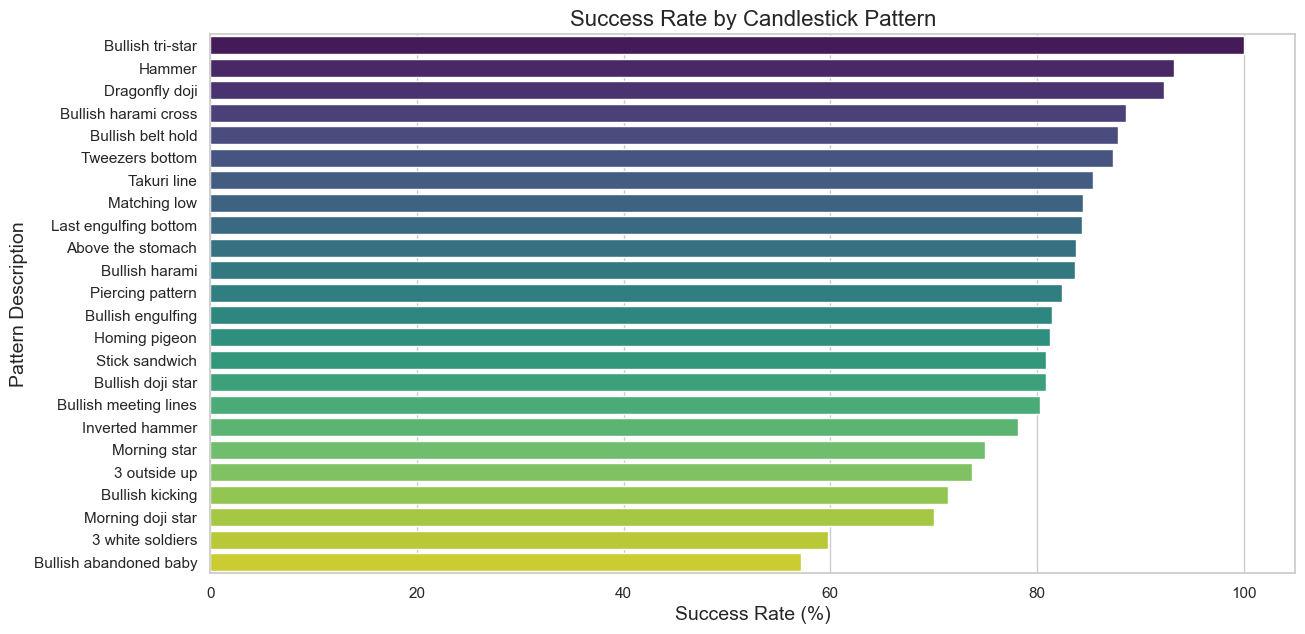

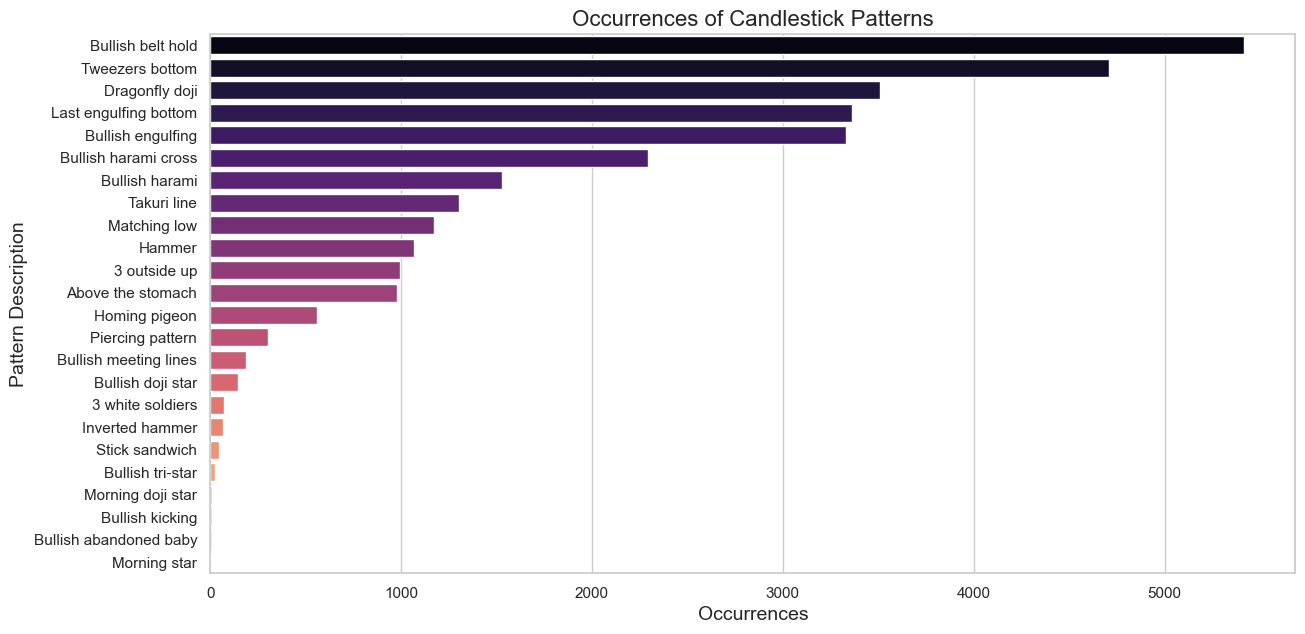

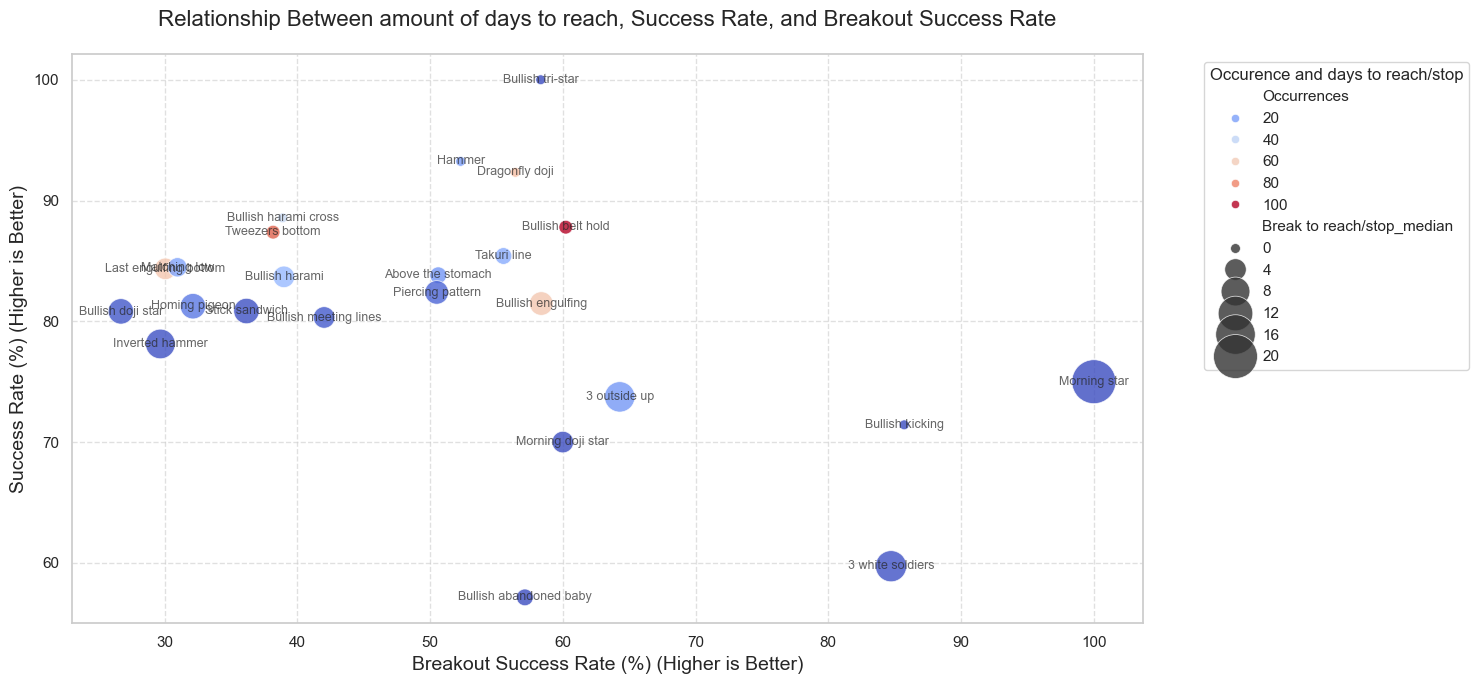

In [256]:
import plotly.express as px

# Set seaborn style
sns.set(style="whitegrid")

# 1. Success Rate vs. Patterns
plt.figure(figsize=(14, 7))
sns.barplot(
    x="Success Rate (%)", 
    y="Pattern Description", 
    data=data.sort_values("Success Rate (%)", ascending=False),
    palette="viridis"
)
plt.title("Success Rate by Candlestick Pattern", fontsize=16)
plt.xlabel("Success Rate (%)", fontsize=14)
plt.ylabel("Pattern Description", fontsize=14)
plt.show()

# 2. Occurrences vs. Patterns
plt.figure(figsize=(14, 7))
sns.barplot(
    x="Occurrences", 
    y="Pattern Description", 
    data=data.sort_values("Occurrences", ascending=False),
    palette="magma"
)
plt.title("Occurrences of Candlestick Patterns", fontsize=16)
plt.xlabel("Occurrences", fontsize=14)
plt.ylabel("Pattern Description", fontsize=14)
plt.show()

# Extracting relevant columns for the 3D bubble plot
x = data['Success Rate (%)']
y = data['Breakout Success Rate (%)']
z = data['Break to reach/stop_median']
annotations = data['Pattern Description']

# Normalize occurrences for better visualization
normalized_data = data.copy()
normalized_data["Occurrences"] = normalized_data["Occurrences"] / normalized_data["Occurrences"].max() * 100


# Create the bubble chart
plt.figure(figsize=(15, 7))
bubble_plot = sns.scatterplot(
    x="Breakout Success Rate (%)",
    y="Success Rate (%)",
    size="Break to reach/stop_median",
    hue="Occurrences",
    data=normalized_data,
    sizes=(50, 1000),
    palette="coolwarm",
    alpha=0.8
)

# Add annotations for each pattern
for i in range(normalized_data.shape[0]):
    plt.text(
        x=normalized_data["Breakout Success Rate (%)"].iloc[i],
        y=normalized_data["Success Rate (%)"].iloc[i],
        s=normalized_data["Pattern Description"].iloc[i],
        fontsize=9,
        ha='center',  # Horizontal alignment
        va='center',  # Vertical alignment
        alpha=0.7
    )

# Customize the plot
bubble_plot.set_title(
    "Relationship Between amount of days to reach, Success Rate, and Breakout Success Rate",
    fontsize=16,
    pad=20
)
bubble_plot.set_xlabel("Breakout Success Rate (%) (Higher is Better)", fontsize=14)
bubble_plot.set_ylabel("Success Rate (%) (Higher is Better)", fontsize=14)
plt.legend(title="Occurence and days to reach/stop", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

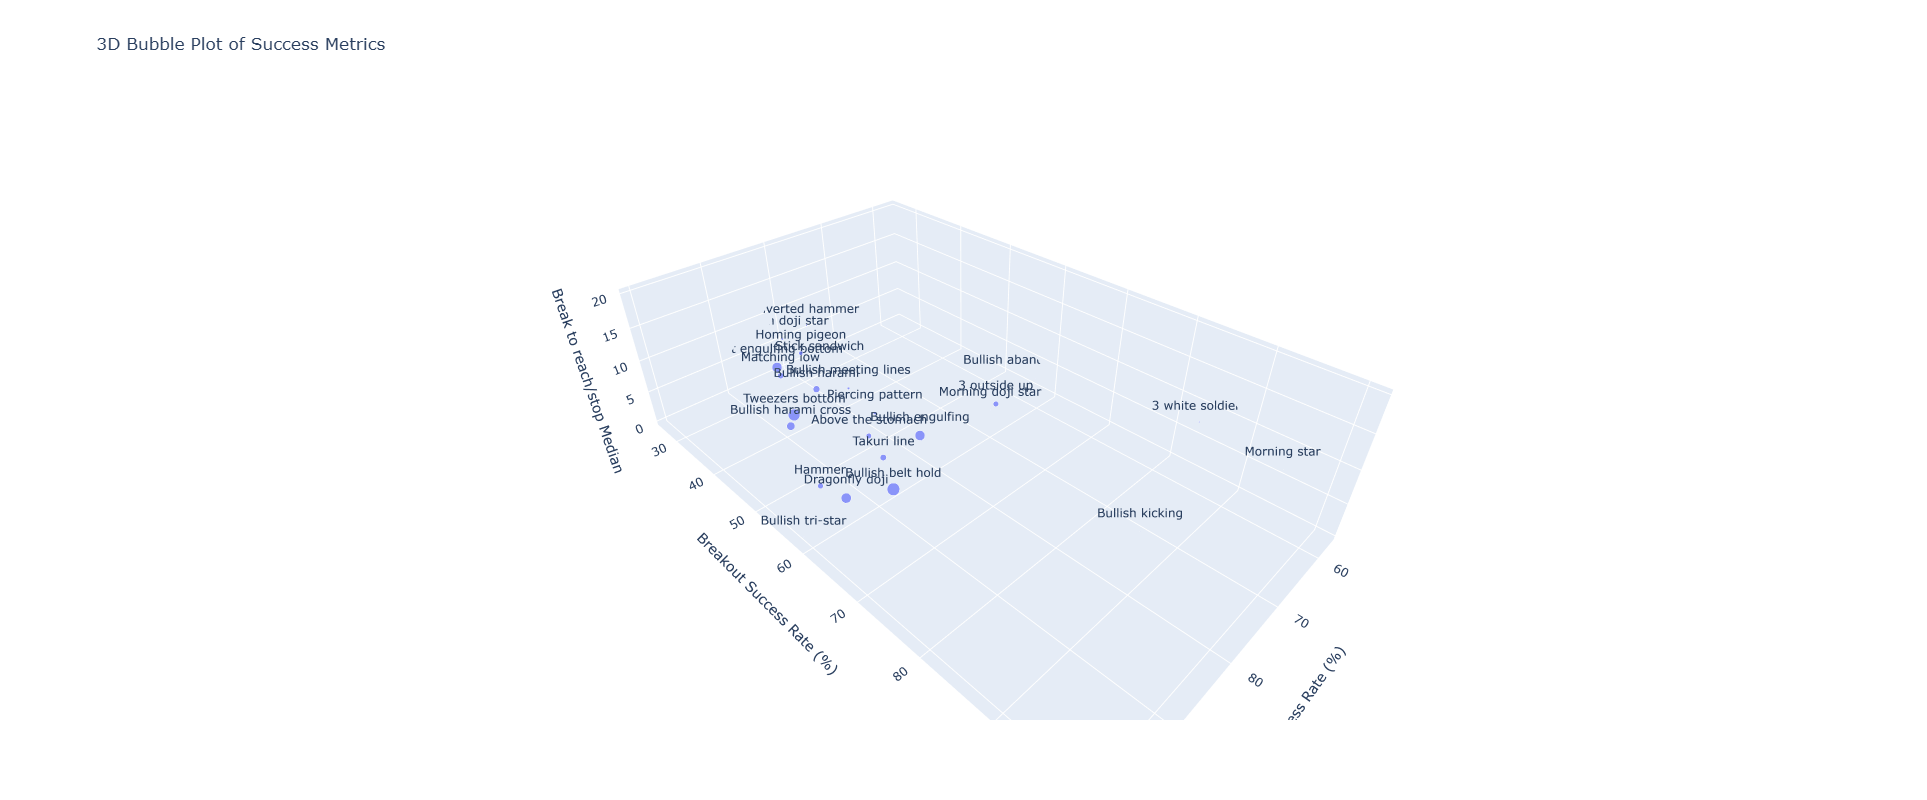

In [258]:
import plotly.express as px
# Creating the 3D bubble plot
fig = px.scatter_3d(
    data, 
    x='Success Rate (%)', 
    y='Breakout Success Rate (%)', 
    z='Break to reach/stop_median',
    text='Pattern Description',
    size='Occurrences',  # Bubble size based on the number of occurrences
    hover_name='Pattern Description',
    title='3D Bubble Plot of Success Metrics',
    labels={
        'Success Rate (%)': 'Success Rate (%)',
        'Breakout Success Rate (%)': 'Breakout Success Rate (%)',
        'Break to reach/stop_median': 'Break to reach/stop Median'
    }
)

# Update layout for better visualization
fig.update_traces(marker=dict(opacity=0.7))
fig.update_layout(scene=dict(
    xaxis_title='Success Rate (%)',
    yaxis_title='Breakout Success Rate (%)',
    zaxis_title='Break to reach/stop Median'
))


# Update layout to make the plot bigger
fig.update_layout(
    width=1300,  # Increase the width of the plot
    height=800,  # Increase the height of the plot
)


# Display the plot
fig.show()


# Visualizations of individual candlestick patterns

### Select the pattern here at `pattern_select`

In [306]:
pattern_select = 'Bullish belt hold'

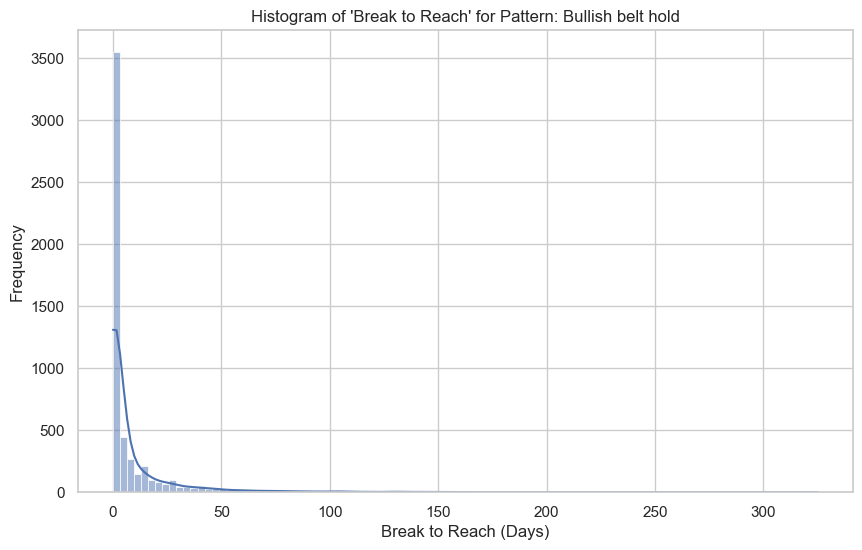

In [233]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select a random pattern description
random_pattern = 'Bullish belt hold'

# Filter data for the selected pattern
filtered_data = df_f[df_f['Pattern Description'] == random_pattern]

# Convert 'Break to reach' to numeric (if it's not already)
filtered_data['Break to reach/stop'] = pd.to_numeric(filtered_data['Break to reach/stop'], errors='coerce')

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['Break to reach/stop'], bins=100, kde=True)
plt.title(f"Histogram of 'Break to Reach' for Pattern: {random_pattern}")
plt.xlabel("Break to Reach (Days)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


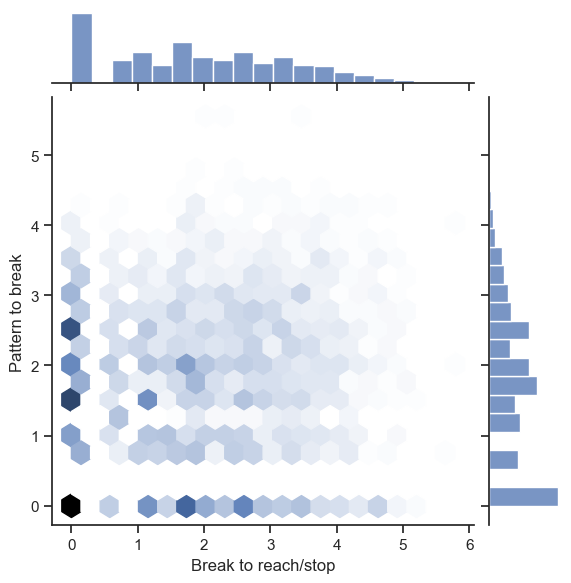

In [308]:
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")

pattern = df_f.loc[df_f['Pattern Description'] == pattern_select].replace(0, np.nan) 
x = pattern['Break to reach/stop'].apply(np.log)
y = pattern['Pattern to break'].apply(np.log)

sns.jointplot(x=x, y=y, kind="hex")
plt.show()

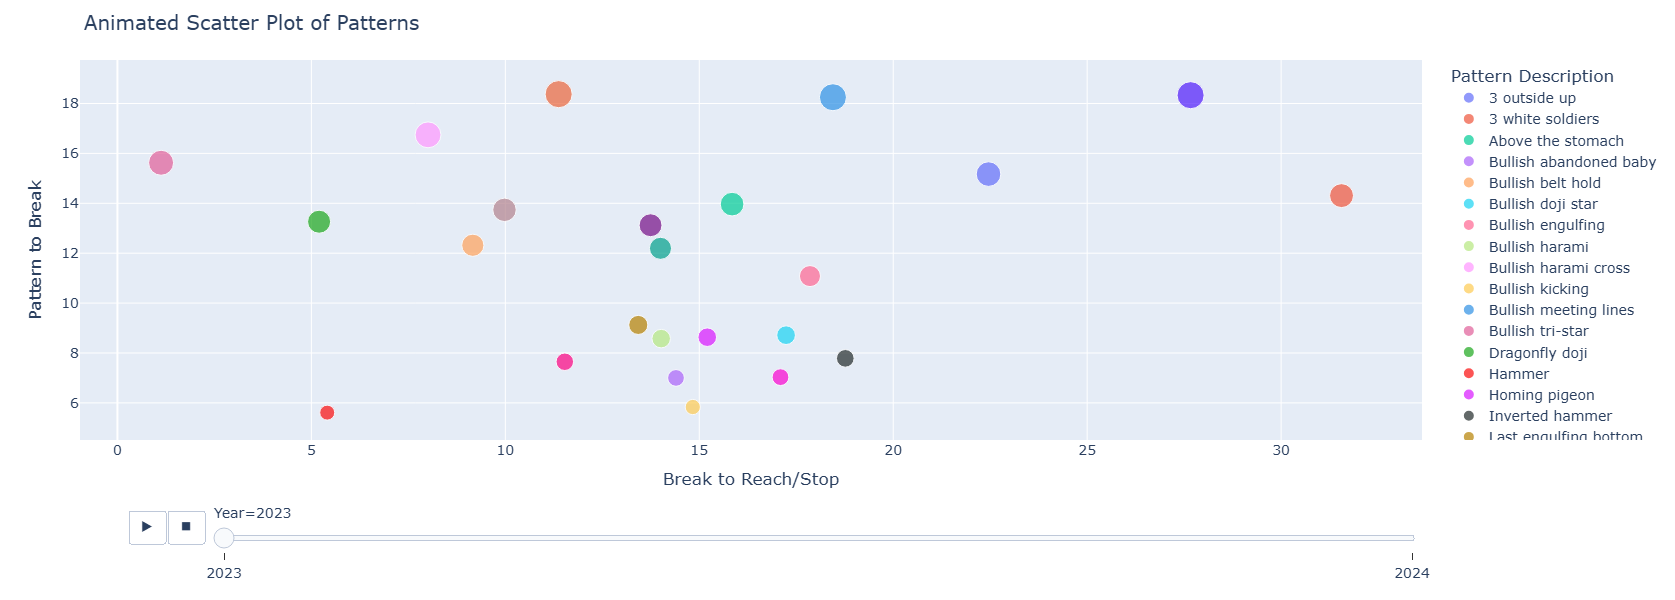

In [376]:
import plotly.express as px
df_c = bur
# Assuming your dataframe is called `df` and the column is named 'Start'
df_c['Year'] = pd.to_datetime(df_c['Start']).dt.year
# This will create a new column 'YearMonth' in the format 'YYYY-MM'
main = df_c.groupby(['Year','Pattern Description','Type of Pattern'])[['Pattern length','Pattern to break','Break to reach/stop']].mean().reset_index()
import plotly.express as px

import plotly.express as px

# Define a custom color palette to handle a larger number of categories
custom_colors = (
    px.colors.qualitative.Plotly + 
    px.colors.qualitative.Dark24 + 
    px.colors.qualitative.Set3
)

# Create an animated scatter plot with custom colors
fig = px.scatter(
    main,
    x="Break to reach/stop",
    y="Pattern to break",
    animation_frame="Year",
    animation_group="Pattern Description",
    size="Pattern to break",
    color="Pattern Description",
    hover_name="Pattern Description",
    color_discrete_sequence=custom_colors  # Use the custom color palette
)

# Optional: Remove animation buttons for a cleaner look
fig.update_layout(
    updatemenus=[]  # Removes the default animation control buttons
)

# Update layout to enhance plot appearance
fig.update_layout(
    title="Animated Scatter Plot of Patterns",  # Add a title
    xaxis_title="Break to Reach/Stop",  # X-axis label
    yaxis_title="Pattern to Break",  # Y-axis label
    width=1000,  # Customize plot width
    height=600,  # Customize plot height
    font=dict(size=14),  # Adjust font size for better readability
)

# Show the plot
fig.show()


In [ ]:
import plotly.express as px
df_c = bur
# Assuming your dataframe is called `df` and the column is named 'Start'
df_c['Year'] = pd.to_datetime(df_c['Start']).dt.year
# This will create a new column 'YearMonth' in the format 'YYYY-MM'
main = df_c.groupby(['Year','Pattern Description','Type of Pattern'])[['Pattern length','Pattern to break','Break to reach/stop']].mean().reset_index()
import plotly.express as px

import plotly.express as px

# Define a custom color palette to handle a larger number of categories
custom_colors = (
    px.colors.qualitative.Plotly + 
    px.colors.qualitative.Dark24 + 
    px.colors.qualitative.Set3
)

# Create an animated scatter plot with custom colors
fig = px.scatter(
    main,
    x="Break to reach/stop",
    y="Pattern to break",
    animation_frame="Year",
    animation_group="Pattern Description",
    size="Pattern to break",
    color="Pattern Description",
    hover_name="Pattern Description",
    color_discrete_sequence=custom_colors  # Use the custom color palette
)

# Optional: Remove animation buttons for a cleaner look
fig.update_layout(
    updatemenus=[]  # Removes the default animation control buttons
)

# Update layout to enhance plot appearance
fig.update_layout(
    title="Animated Scatter Plot of Patterns",  # Add a title
    xaxis_title="Break to Reach/Stop",  # X-axis label
    yaxis_title="Pattern to Break",  # Y-axis label
    width=1000,  # Customize plot width
    height=600,  # Customize plot height
    font=dict(size=14),  # Adjust font size for better readability
)

# Show the plot
fig.show()


In [378]:
df_f

,Pattern Description,Bullish/Bearish/Both,Start,End,Breakout Date,Reach/Stop Date,Breakout,Avg 3 Mo. Volume,Breakout result,Trade Status,Type of Pattern,Pattern length,Pattern to break,Break to reach/stop
2,Long black day,Bearish,2023-04-26,2023-04-26,2023-05-04,2023-05-05,Down,7566,Success,Reached,Continuation,0,8,1
5,White marubozu,Bullish,2023-04-28,2023-04-28,2023-05-04,2023-05-04,Down,7561,Fail,Reached,Continuation,0,6,0
6,Bullish engulfing,Bullish,2023-04-27,2023-04-28,2023-05-04,2023-05-05,Down,7561,Fail,Reached,Reversal,1,6,1
7,Bullish belt hold,Bullish,2023-04-28,2023-04-28,2023-05-04,2023-05-04,Down,7561,Fail,Reached,Reversal,0,6,0
9,Closing black marubozu,Bearish,2023-05-04,2023-05-04,2023-05-05,2023-05-05,Down,755,Success,Reached,Continuation,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288474,Long black day,Bearish,2024-04-01,2024-04-01,2024-04-02,2024-04-03,Down,1112,Success,Reached,Continuation,0,1,1
288475,Black marubozu,Bearish,2024-04-02,2024-04-02,2024-04-04,2024-04-04,Up,1111,Fail,Reached,Continuation,0,2,0
288477,White marubozu,Bullish,2024-04-05,2024-04-05,2024-04-22,2024-05-08,Up,1111,Success,Triggered,Continuation,0,17,16
288478,Below the stomach,Bearish,2024-04-05,2024-04-16,2024-04-22,2024-05-08,Up,1109,Fail,Triggered,Reversal,11,6,16
